In [5]:
begin
    using Pkg
    dev_folder = (@__DIR__) * "/.."
    Pkg.activate(dev_folder)
end

# ONLY run this block once to set up the development environment
# begin
#     pkg_folder = joinpath(dev_folder, "..")
#     Pkg.develop(path=pkg_folder)
#     Pkg.instantiate()
# end

Threads.nthreads()

  Activating project at `~/Realizibility_index/BindingAndCatalysis.jl/Examples`


24

In [144]:
using Revise
using BindingAndCatalysis 
using GLMakie

import Markdown; Base.showable(::MIME"text/markdown", ::Markdown.MD) = false # if you are using vscode, you should run this line 

The simplest cases, three species have to bind at the same time to form a trimer complex.

In [15]:
model = let
    x_sym = [:R, :S, :T, :C_RST]
    q_sym = [:R_tot, :S_tot, :T_tot]
    N =     [1 1 1 -1]
    Bnc(N=N, x_sym=x_sym, q_sym=q_sym)
end
find_all_vertices!(model)
summary(model)

[ Info: ---------------------Start finding all vertices--------------------
[ Info: Finished, with 8 vertices found and 8 asymptotic vertices.


----------Binding Network Summary:-------------
Number of species (n): 4
Number of conserved quantities (d): 3
Number of reactions (r): 1
L matrix: [1 0 0 1; 0 1 0 1; 0 0 1 1]
N matrix: [1 1 1 -1]
Direction of binding reactions: backward
Catalysis involved: No
Regimes constructed: Yes
Number of regimes: 8
  - Invertible + Asymptotic: 4
  - Singular +  Asymptotic: 4
  - Invertible +  Non-Asymptotic: 0
  - Singular +  Non-Asymptotic: 0
-----------------------------------------------


[ Info: -------------Start calculating nullity for each vertex, it also takes a while.------------
[ Info: 1.Building Nρ_inv cache in parallel...
[ Info: 2.Calculating nullity for each vertex in parallel...


In [ ]:
f,ax,p = draw_graph(model;)

[ Info: Start calculating vertices neighbor graph, It may takes a while.
[ Info: Calculating vertices neighbor graph with qK change dir
[ Info: Number of polyhedra to calc volume: 4
[ Info: All regimes converged after 600000 samples.


(Scene(1 children, 0 plots), Axis (2 plots), Plot{GraphMakie.graphplot, Tuple{Graphs.SimpleGraphs.SimpleDiGraph{Int64}}})

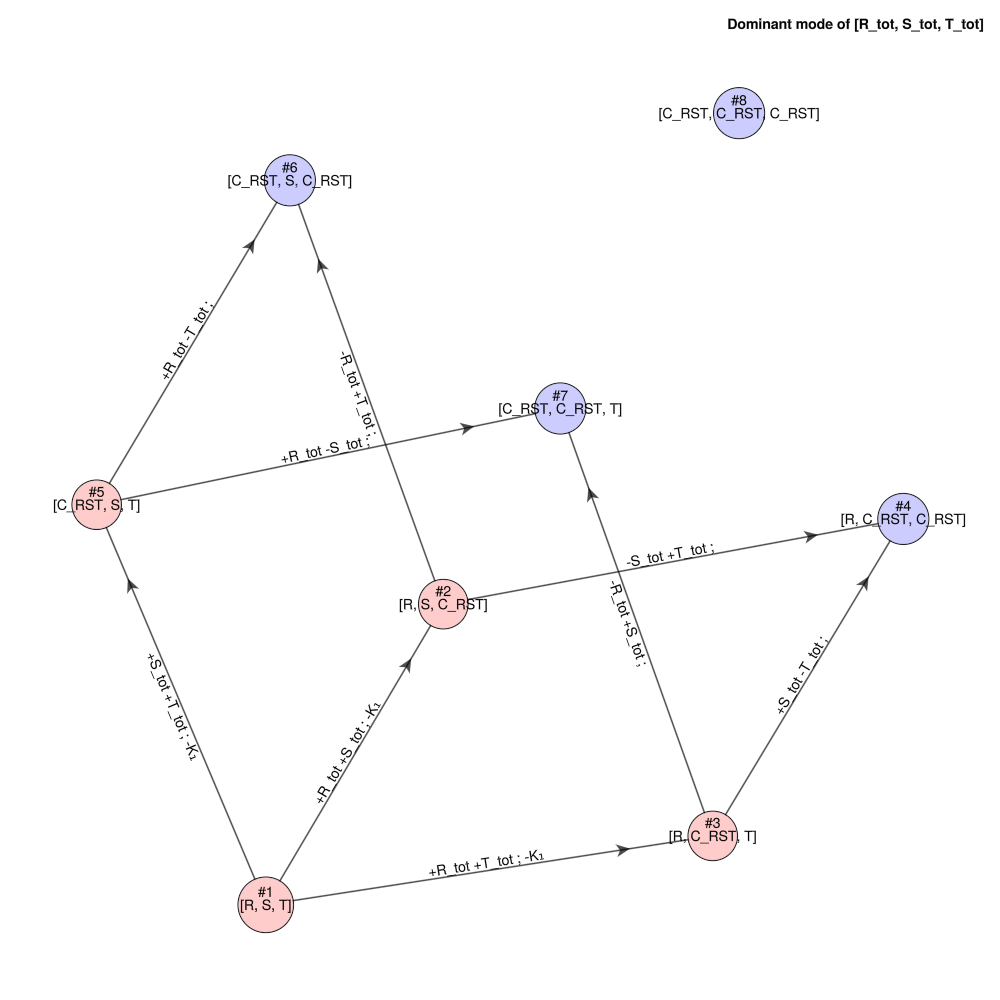

In [28]:
f

In [18]:
inv_regimes = get_vertices(model; singular=false)

4-element Vector{Vector{Int8}}:
 [1, 2, 3]
 [1, 2, 4]
 [1, 4, 3]
 [4, 2, 3]

In [23]:
show_expression_x.(Ref(model), inv_regimes; log_space=false) .|> x-> x[4]

4-element Vector{Symbolics.Equation}:
 C_RST ~ (R_tot*S_tot*T_tot) / K₁
 C_RST ~ T_tot
 C_RST ~ S_tot
 C_RST ~ R_tot

In [31]:
show_condition_qK(model, inv_regimes[1]) # indeed T_tot is min(T_tot,R_tot,S_tot) 

3-element Vector{Symbolics.Num}:
 (-log10(S_tot) - log10(T_tot) + log10(K₁)) > 0
 (-log10(T_tot) + log10(K₁) - log10(R_tot)) > 0
 (-log10(S_tot) + log10(K₁) - log10(R_tot)) > 0

In [ ]:
# Is this hill function?
guss_c_func(lgtR, lgtS, lgtT, lgK) = let 
    K = exp(lgK)
    tR = exp(lgtR)
    tS = exp(lgtS)
    tT = exp(lgtT)
    C_rgm1 = tR*tS*tT/K
    C_rgm2 = tT
    C_rgm3 = tS
    C_rgm4 = tR
    return log(1 / (1/C_rgm1 + 1/C_rgm2 + 1/C_rgm3 + 1/C_rgm4))
end
    

guss_c_func (generic function with 1 method)

In [84]:
qK_smp = vcat.(randomize(3,10000),[0]) # let K be zero(normalized to K)

10000-element Vector{Vector{Float64}}:
 [4.093417631026913, 4.7176548581459326, -1.3941880125156256, 0.0]
 [2.25742213133503, -2.327410734376567, 3.260398689735034, 0.0]
 [1.0130596313981677, 0.445322003104776, -4.055925507212587, 0.0]
 [-0.7931680553847045, -5.77269314828881, 5.922275041007609, 0.0]
 [5.905295280660706, 2.0283939196458984, -2.0112834243627096, 0.0]
 [0.527102525707793, 5.917106999508414, -5.692549454864673, 0.0]
 [-4.254483463936921, -2.139066895979568, 5.413754528014252, 0.0]
 [3.9125593418985662, 2.4395572328134616, 5.435971861605434, 0.0]
 [4.470089025176755, -5.220610708086362, 0.5669683599132949, 0.0]
 [-3.23000401580894, 0.9348163445777686, 4.261478494936133, 0.0]
 [-0.561175320289423, 5.388480545782624, 4.240984039661324, 0.0]
 [1.2905839563171035, -4.640846913098432, -5.205758134747253, 0.0]
 [5.443533709410616, -0.6422291421708586, -3.716082940677976, 0.0]
 ⋮
 [-3.547226354015503, -4.08648358556868, -3.3828412505074676, 0.0]
 [-0.9204144008563047, -0.67582937

In [85]:
x_from_qK_smp = begin
    a = Vector{Vector{Float64}}(undef, length(qK_smp))
    Threads.@threads for i in eachindex(qK_smp)
        a[i] = qK2x(model, qK_smp[i]; input_logspace=true, output_logspace=true)
    end
    a
end
# Threads.@threads qK2x.(Ref(model), qK_smp; input_logspace=true, output_logspace=true)

10000-element Vector{Vector{Float64}}:
 [4.093416217905837, 4.717654522453456, -10.205258753545905, -1.3941880131866118]
 [2.2574108345262958, -7.845220454867891, 3.260397567783414, -2.327412052558181]
 [1.0130560509065472, 0.4453087692880266, -5.5291486286741565, -4.070783808479583]
 [-0.7931726079718581, -10.901798807441809, 5.922275041006732, -5.7726963744069355]
 [5.905295275398043, 2.028354280272405, -9.944932985092974, -2.011283429422526]
 [0.5271022638097185, 5.9171069995073475, -12.136758874343597, -5.692549611026531]
 [-7.526063095286792, -2.1424073419398253, 5.413754527921074, -4.254715909305536]
 [3.897693346391444, -6.893669859780711, 5.435533746001098, 2.4395572326118304]
 [4.470089025088226, -10.25767137254241, 0.5669676516387891, -5.220614695815394]
 [-8.426271890167444, 0.9347866295565666, 4.261478480930619, -3.230006779680257]
 [-10.190632569143256, 5.388480058109649, 4.240977190642249, -0.5611753203913588]
 [1.2905839562553114, -4.640899683444147, -5.205951942736825, 

In [86]:
x_guss = qK_smp .|> x-> guss_c_func(x...)

10000-element Vector{Float64}:
  -1.4006702326868417
  -2.3452145624051384
  -4.279066152880897
  -5.785419335695009
  -2.0294437828519456
  -5.696131747113503
  -4.401587943037335
   2.1932525856630334
  -5.2301848063318355
  -3.251400825028399
  -0.5720010054501128
  -8.609623592997504
  -3.769213028375444
   ⋮
 -11.018581238547421
  -1.964351543725501
  -5.50208314920275
  -3.3990129570839427
   2.8278780371640115
  -1.3404975485772623
  -3.8980322780704575
  -4.889995270882636
  -1.5128420034586991
  -3.3862273192913115
   0.8553414464443575
  -2.28491874220231

In [230]:
error_C = getindex.(x_from_qK_smp,4) .- x_guss
qK_error = qK_smp[abs.(error_C) .> 0.5]
x_error = x_from_qK_smp[abs.(error_C) .> 0.5]
rgms = assign_vertex_x.(Ref(model), x_from_qK_smp; return_idx=true)

10000-element Vector{Int64}:
 2
 3
 2
 3
 2
 2
 5
 3
 3
 5
 5
 1
 2
 ⋮
 1
 1
 3
 2
 2
 5
 1
 2
 5
 5
 5
 3

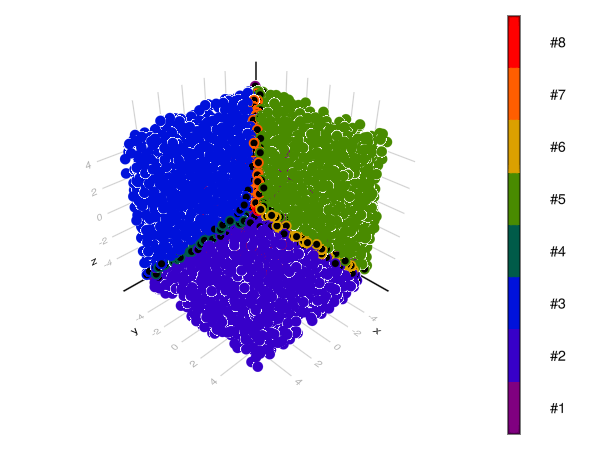

In [231]:
f,ax,p = let 

    
    qK_pts =  qK_smp .|> x-> Point3(x[1:3])
    cmap = get_color_map(rgms) # get colormap 
    colors = getindex.(Ref(cmap),rgms)

    f,ax,p = scatter(qK_pts, color = colors, markersize=15)
    

    # add error points
    plot!(ax, getindex.(qK_error,Ref(1:3)) .|> x-> Point3(x), color=:black, markersize=10)

    # add regime label
    add_rgm_colorbar!(f, cmap)
    f,ax,p 
end

# check if these error points are near the boundaries
f

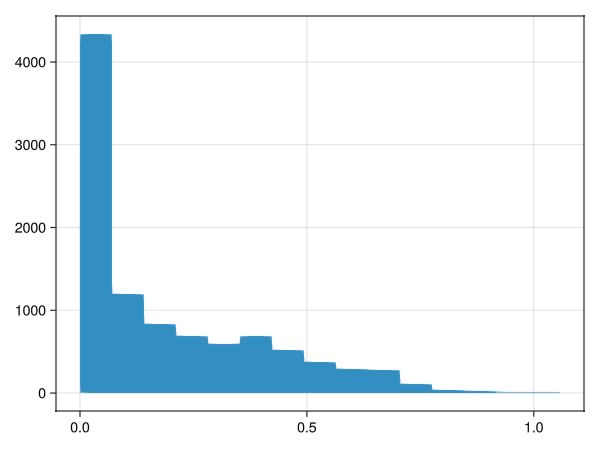

In [232]:
hist(error_C)

In [233]:
# Try another way to visualize, the ROP POV

In [235]:
RO_C = get_H.(Ref(model), inv_regimes) .|> x->x[4,1:3] |> Point3

4-element Vector{Point{3, Float64}}:
 [1.0, 1.0, 1.0]
 [0.0, 0.0, 1.0]
 [0.0, 1.0, 0.0]
 [1.0, 0.0, 0.0]

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie ~/.julia/packages/Makie/Vn16E/src/scenes.jl:264


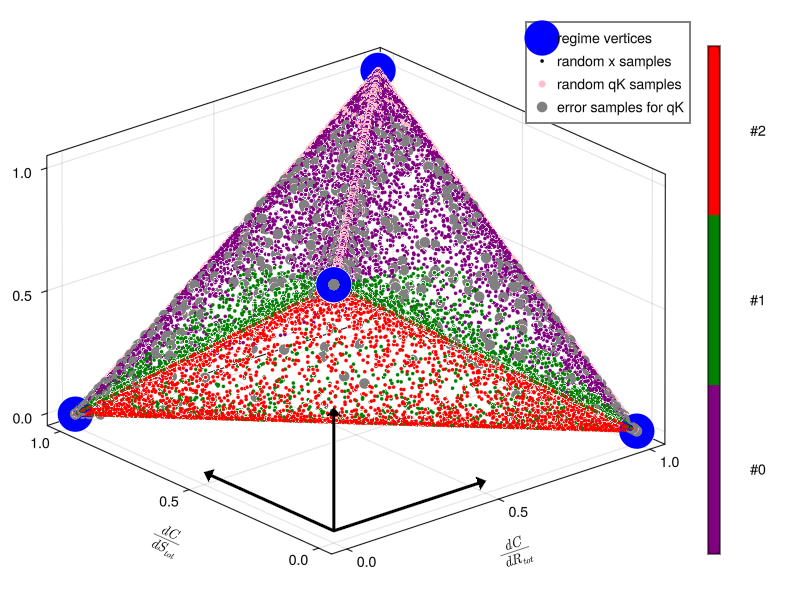

In [ ]:
get_c_ord(x) = logder_x_qK(model; x = x, input_logspace=true) |> x-> x[4,1:3] |> Point3

f,ax,p = let 
    verteices = RO_C
    x_smp = randomize(model,100000)
    ord_x_space = x_smp .|> get_c_ord

    rgms = assign_vertex_x.(Ref(model), x_smp; return_idx=true) .|> x->get_nullity(model, x)  # We color by nullity here!!!
    cmap = get_color_map(rgms) # get colormap 
    colors = getindex.(Ref(cmap),rgms)

    ord_qK_space = x_from_qK_smp .|> get_c_ord
    ord_error_space =  x_error .|> get_c_ord
    
    f = Figure(size = (800, 600))
    ax = Axis3(f[1, 1]; xlabel=L"\frac{dC}{dR_{tot}}", ylabel=L"\frac{dC}{dS_{tot}}", zlabel=L"\frac{dC}{dT_{tot}}")
    scatter!(ax, verteices, color = :blue, markersize=50, label="regime vertices")
    scatter!(ax, ord_x_space, color = colors, markersize=5, label="random x samples")
    scatter!(ax, ord_qK_space, color = :pink, markersize=10, label="random qK samples")
    scatter!(ax, ord_error_space, color = :gray, markersize=15, label="error samples for qK")

    arrows2d!(ax, fill(Point3f(0,0,0), 3), Vec3f[(1,0,0), (0,1,0), (0,0,1)], color=:black,lengthscale = 0.5)
    
    add_rgm_colorbar!(f, cmap)
    axislegend(ax)
    f,ax,p
end
f

In [245]:
grh_1 = SISOPaths(model,1)

[ Info: sources: [5, 1]
[ Info: sinks: [2, 3]
[ Info: Start enumerating paths from sources to sinks. This may take a while if there are many paths.
[ Info: Total vertices to process in topological order: 8
[ Info: Finished enumerating paths. Now collecting paths from sources. Total sources: 2


SISOPaths{Int8}(Bnc{Int8}([1 1 1 -1], [1 0 0 1; 0 1 0 1; 0 0 1 1], 1, 4, 3, Symbolics.Num[R, S, T, C_RST], Symbolics.Num[R_tot, S_tot, T_tot], Symbolics.Num[K₁], nothing, Vector{Int8}[[1, 2, 3], [1, 2, 4], [1, 4, 3], [1, 4, 4], [4, 2, 3], [4, 2, 4], [4, 4, 3], [4, 4, 4]], Dict{Vector{Int8}, Int64}([4, 4, 4] => 8, [1, 4, 3] => 3, [4, 2, 3] => 5, [1, 4, 4] => 4, [4, 2, 4] => 6, [1, 2, 3] => 1, [1, 2, 4] => 2, [4, 4, 3] => 7), Bool[1, 1, 1, 1, 1, 1, 1, 1], Int8[0, 0, 0, 1, 0, 1, 1, 2], BindingAndCatalysis.VertexGraph{Int8}(Bnc{Int8}(#= circular reference @-2 =#), Graphs.SimpleGraphs.SimpleGraph{Int64}(12, [[2, 3, 5], [1, 4, 6], [1, 4, 7], [2, 3, 8], [1, 6, 7], [2, 5, 8], [3, 5, 8], [4, 6, 7]]), Vector{BindingAndCatalysis.VertexEdge{Int8}}[[BindingAndCatalysis.VertexEdge{Int8}(2, 3, sparsevec(Int8[3, 4], Int8[-1, 1], 4), -0.0, sparsevec(Int8[1, 2, 4], [1.0, 1.0, -1.0], 4), 0.0), BindingAndCatalysis.VertexEdge{Int8}(5, 1, sparsevec(Int8[1, 4], Int8[-1, 1], 4), -0.0, sparsevec(Int8[2, 3, 4],

In [248]:
summary(grh_1)

[ Info: Start building polyhedra for edges (total: 6)
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
[ Info: Start building polyhedra for paths (total: 4)
Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
[ Info: Number of polyhedra to calc volume: 4


Path 1         #1 → #2       Volume: 0.2493 ± 0.0012
Path 2         #1 → #3       Volume: 0.2499 ± 0.0012


[ Info: All regimes converged after 500000 samples.


Path 3         #5 → #6 → #2  Volume: 0.2507 ± 0.0012
Path 4         #5 → #7 → #3  Volume: 0.2501 ± 0.0012


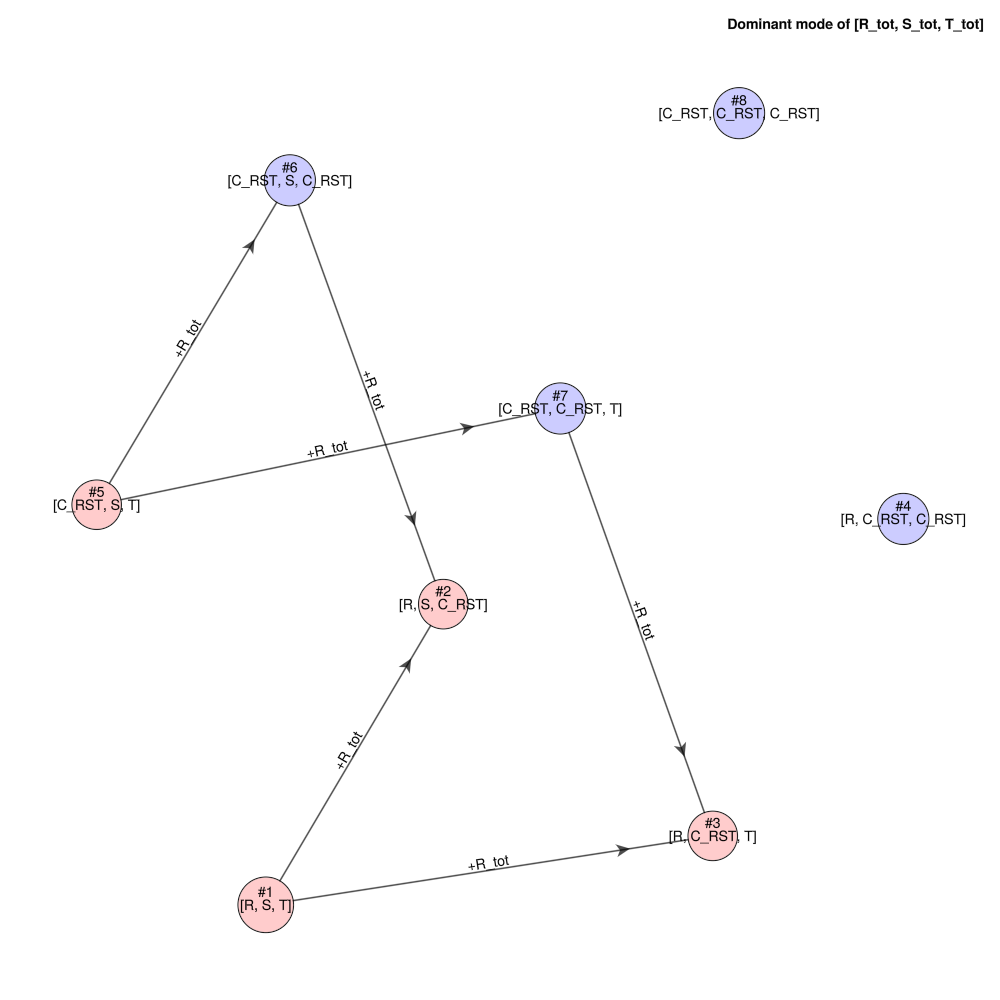

In [247]:
f,ax,p = draw_graph(grh_1)
f

In [255]:
get_traj_x(i) = let
    p = get_one_inner_point(grh_1,i)
    lgx = x_traj_with_qK_change(model, vcat([-6],p),vcat([6],p); input_logspace=true,output_logspace=true, npoints=1000)[2]
    lgx
end

get_traj_x (generic function with 1 method)

In [254]:
lgx[2]

1000-element Vector{Vector{Float64}}:
 [-6.000000319048613, -1.4230620255729567, -4.53356891969094, -12.133926276275893]
 [-6.000000319048613, -1.4230620255729567, -4.53356891969094, -12.133926276275893]
 [-6.000000319048613, -1.4230620255729567, -4.53356891969094, -12.133926276275893]
 [-6.000000319048613, -1.4230620255729567, -4.53356891969094, -12.133926276275893]
 [-6.000000319048613, -1.4230620255729567, -4.53356891969094, -12.133926276275893]
 [-6.000000319048613, -1.4230620255729567, -4.53356891969094, -12.133926276275893]
 [-6.000000319048613, -1.4230620255729567, -4.53356891969094, -12.133926276275893]
 [-6.000000319048613, -1.4230620255729567, -4.53356891969094, -12.133926276275893]
 [-6.000000319048613, -1.4230620255729567, -4.53356891969094, -12.133926276275893]
 [-6.000000319048613, -1.4230620255729567, -4.53356891969094, -12.133926276275893]
 [-6.000000319048613, -1.4230620255729567, -4.53356891969094, -12.133926276275893]
 [-6.000000319048613, -1.4230620255729567, -4.533

In [ ]:
f,ax,p = let 
    verteices = RO_C
    x_smp = randomize(model,100000)
    ord_x_space = x_smp .|> get_c_ord

    rgms = assign_vertex_x.(Ref(model), x_smp; return_idx=true) #.|> x->get_nullity(model, x) 
    cmap = get_color_map(rgms) # get colormap 
    colors = getindex.(Ref(cmap),rgms)

    ord_qK_space = x_from_qK_smp .|> get_c_ord
    ord_error_space =  x_error .|> get_c_ord
    
    f = Figure(size = (1000, 1000))
    ax = Axis3(f[1, 1]; xlabel=L"\frac{dC}{dR_{tot}}", ylabel=L"\frac{dC}{dS_{tot}}", zlabel=L"\frac{dC}{dT_{tot}}")
    scatter!(ax, verteices, color = :blue, markersize=50, label="regime vertices")
    scatter!(ax, ord_x_space, color = colors, markersize=5, label="random x samples")
    # scatter!(ax, ord_qK_space, color = :pink, markersize=10, label="random qK samples")
    # scatter!(ax, ord_error_space, color = :gray, markersize=15, label="error samples for qK")

    arrows2d!(ax, fill(Point3f(0,0,0), 3), Vec3f[(1,0,0), (0,1,0), (0,0,1)], color=:black,lengthscale = 0.5)
    
    add_rgm_colorbar!(f, cmap)
    axislegend(ax)
    f,ax,p
end
f